In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
file_path = '../data/data.csv'
df = pd.read_csv(file_path, parse_dates=['Date'])
#df = df.dropna()


In [3]:
threshold = df['volatility_forcast'].mean() * 1.3
df['high_volatility'] = np.where(df['volatility_forcast'] > threshold, 1, 0)  # 1: High, 0: Low

print(df['high_volatility'].value_counts())

df.head()

high_volatility
0    4218
1    1151
Name: count, dtype: int64


,Date,Inflation,CPI,Treasury_Yield,Open,High,Low,Close,SP500_Adj_Close,Volume,...,volatility_forcast,returns,EWMA_VM,GARCH_VM,EGARCH_VM,RogersSatchell_VM,garman_klass,parkinson,yang_zhang,high_volatility
0,2003-01-03,1.62,182.6,4.05,909.03,911.25,903.07,908.59,908.59,1130800000,...,2.5512,-0.0005,0.0116,0.0002,0.0182,0.0069,0.0064,0.0054,0.0090,1
1,2003-01-06,1.63,182.6,4.09,908.59,931.77,908.59,929.01,929.01,1435900000,...,1.1827,0.0222,0.0112,0.0003,0.0267,0.0086,0.0112,0.0151,0.0252,0
2,2003-01-07,1.62,182.6,4.04,929.01,930.81,919.93,922.93,922.93,1545200000,...,1.6085,-0.0066,0.0122,0.0003,0.0376,0.0070,0.0072,0.0071,0.0118,1
3,2003-01-08,1.71,182.6,4.00,922.93,922.93,908.32,909.93,909.93,1467600000,...,2.0199,-0.0142,0.0119,0.0004,0.0512,0.0053,0.0070,0.0096,0.0160,1
4,2003-01-09,1.78,182.6,4.19,909.93,928.31,909.93,927.57,927.57,1560300000,...,1.6597,0.0192,0.0121,0.0004,0.0675,0.0040,0.0076,0.0120,0.0200,1


In [4]:
X = df.drop(columns=['Date', 'high_volatility','volatility_forcast'])
y = df['high_volatility']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)


In [7]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(2, activation='softmax')
])

In [8]:
# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)

In [10]:
# Train
history = model.fit(X_train_scaled, y_train_encoded, validation_data=(X_test_scaled, y_test_encoded),
                    epochs=100, batch_size=32, callbacks=[early_stopping, lr_scheduler])

Epoch 1/100


135/135 [==============================] - 2s 6ms/step - loss: 0.8483 - accuracy: 0.8175 - val_loss: 0.7391 - val_accuracy: 0.8343 - lr: 0.0010
Epoch 2/100
135/135 [==============================] - 1s 4ms/step - loss: 0.7402 - accuracy: 0.8319 - val_loss: 0.6889 - val_accuracy: 0.8408 - lr: 0.0010
Epoch 3/100
135/135 [==============================] - 1s 4ms/step - loss: 0.6777 - accuracy: 0.8396 - val_loss: 0.6162 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 4/100
135/135 [==============================] - 1s 4ms/step - loss: 0.6246 - accuracy: 0.8484 - val_loss: 0.5727 - val_accuracy: 0.8678 - lr: 0.0010
Epoch 5/100
135/135 [==============================] - 1s 4ms/step - loss: 0.5867 - accuracy: 0.8442 - val_loss: 0.5647 - val_accuracy: 0.8436 - lr: 0.0010
Epoch 6/100
135/135 [==============================] - 1s 4ms/step - loss: 0.5461 - accuracy: 0.8489 - val_loss: 0.5144 - val_accuracy: 0.8547 - lr: 0.0010
Epoch 7/100
135/135 [==============================] - 1s 5ms/

In [11]:
loss, accuracy = model.evaluate(X_test_scaled, y_test_encoded)
print(f'Test Accuracy: {accuracy}')

34/34 [==============================] - 0s 2ms/step - loss: 0.3519 - accuracy: 0.8669
Test Accuracy: 0.866852879524231


In [12]:
y_pred = model.predict(X_test_scaled)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test_encoded, axis=1)


34/34 [==============================] - 0s 2ms/step


In [13]:
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       844
           1       0.76      0.55      0.64       230

    accuracy                           0.87      1074
   macro avg       0.82      0.75      0.78      1074
weighted avg       0.86      0.87      0.86      1074



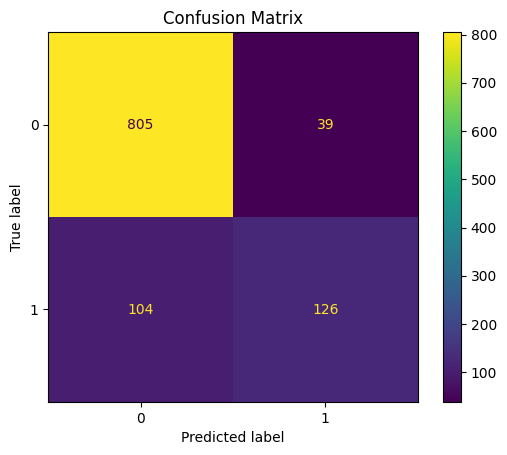

In [14]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels)
plt.title('Confusion Matrix')
plt.show()


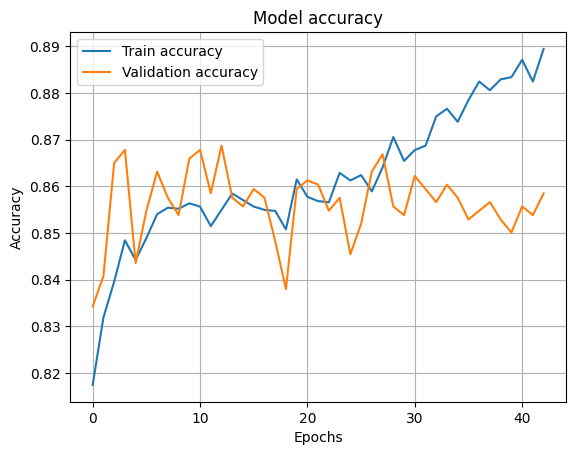

In [15]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()
